In [40]:
!pip install ucimlrepo

In [41]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [42]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
diabetes_130_us_hospitals_for_years_1999_2008 = fetch_ucirepo(id=296)

# data (as pandas dataframes)
X = diabetes_130_us_hospitals_for_years_1999_2008.data.features
y = diabetes_130_us_hospitals_for_years_1999_2008.data.targets

/usr/local/lib/python3.10/dist-packages/ucimlrepo/fetch.py:97: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(data_url)


In [ ]:
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import seaborn as sns
import numpy as np
import scipy.stats as stats

In [ ]:
X.columns

Index(['race', 'gender', 'age', 'weight', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'payer_code', 'medical_specialty', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'diag_1', 'diag_2', 'diag_3',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed'],
      dtype='object')

In [ ]:
# split up categorical and numerical values
cat_values = [
    "race", "gender", "age", "weight", "admission_type_id",
    "discharge_disposition_id", "admission_source_id", "payer_code",
    "medical_specialty", "diag_1", "diag_2", "diag_3", "number_diagnoses",
    "max_glu_serum", "A1Cresult", "metformin", "repaglinide", "nateglinide",
    "chlorpropamide", "glimepiride", "acetohexamide", "examide", "tolazamide",
    "troglitazone", "miglitol", "acarbose", "rosiglitazone", "pioglitazone",
    "tolbutamide", "glyburide", "glipizide", "diabetesMed", "change",
    "metformin-pioglitazone", "metformin-rosiglitazone",
    "glimepiride-pioglitazone", "glipizide-metformin", "glyburide-metformin",
    "insulin", "citoglipton"
]

num_values = [
    'time_in_hospital',
    'num_lab_procedures',
    'num_procedures',
    'num_medications',
    'number_outpatient',
    'number_emergency',
    'number_inpatient'
]
len(cat_values)

40

Categorical Feature Selection

In [ ]:
features_cat = []
results = {
    'Feature': [],
    'Chi-Square Statistic': [],
    'Degrees of Freedom': [],
    'P-value': [],
    'Pass': []  # Pass or Fail
}

alpha = 0.05

# chi squared on all categorical values
for cat_value in cat_values:
    contingency_table = pd.crosstab(X[cat_value], y['readmitted'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

    # Store results in the dictionary
    results['Feature'].append(cat_value)
    results['Chi-Square Statistic'].append(chi2)  # Round to 2 decimal points
    results['Degrees of Freedom'].append(dof)
    results['P-value'].append(round(p, 2))  # Round to 2 decimal points

    # Compare p-value to alpha
    if p <= alpha:
        results['Pass'].append(True)
        features_cat.append(cat_value)
    else:
        results['Pass'].append(False)

# Create a DataFrame from the results dictionary
chi2_categorical_df = pd.DataFrame(results)

# Print the DataFrame
chi2_categorical_df[chi2_categorical_df['Pass'] == True]
chi2_categorical_df.to_csv('chi2_categorical.csv', index=False)

Numerical Feature Selection

In [ ]:
feature_num = []
kendall_results = {
    'Feature': [],
    'Kendall Coefficient': [],
    'P-value': [],
    'Pass': []
}

# Set significance level (alpha)
alpha = 0.05

# Run Kendall's rank correlation test for numerical values
for num_feature in num_values:
    kendall_coeff, p_value = stats.kendalltau(X[num_feature], y['readmitted'])

    # Store results in the Kendall results dictionary
    kendall_results['Feature'].append(num_feature)
    kendall_results['Kendall Coefficient'].append(kendall_coeff)
    kendall_results['P-value'].append(p_value)

    # Determine if it passed or failed the test based on alpha
    if p_value <= alpha:
        kendall_results['Pass'].append(True)
        feature_num.append(num_feature)
    else:
        kendall_results['Pass'].append(False)

kendall_df = pd.DataFrame(kendall_results)
feature_num

['time_in_hospital',
 'num_lab_procedures',
 'num_procedures',
 'num_medications',
 'number_outpatient',
 'number_emergency',
 'number_inpatient']

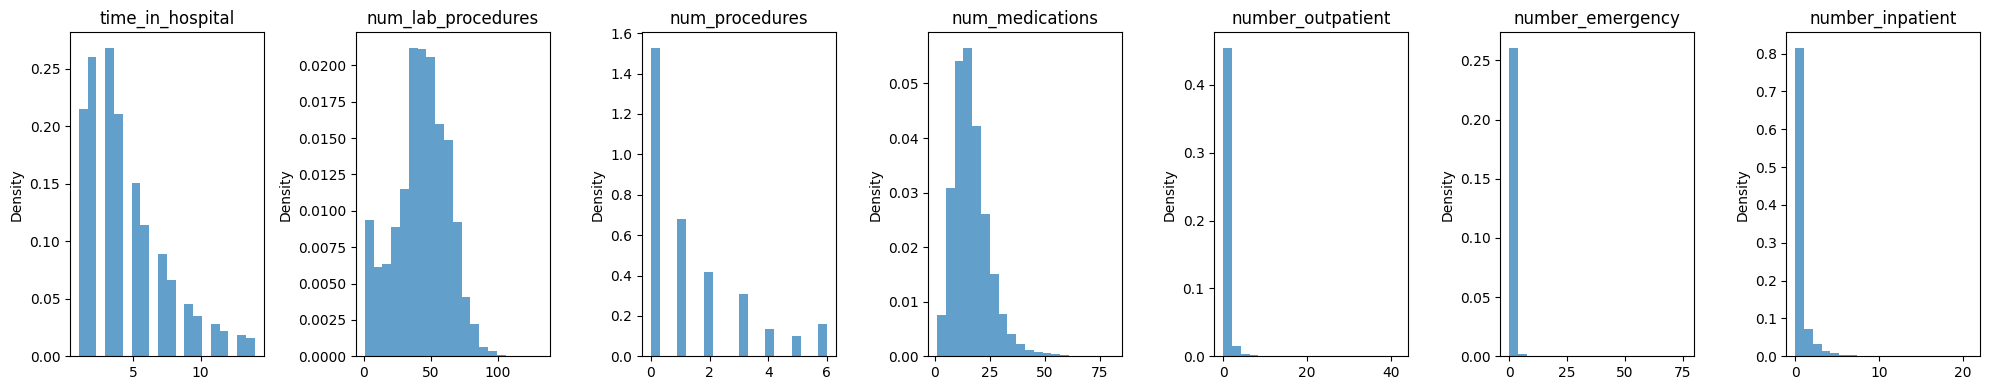

In [ ]:
# Create subplots for the distributions of each column
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(20, 4))
a = 0
# Loop through each column and plot its distribution
for col in num_values:
    ax = axes[a]
    ax.hist(X[col], bins=20, density=True, alpha=0.7)
    ax.set_title(f'{col}')
    ax.set_xlabel('')
    ax.set_ylabel('Density')
    a += 1

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
def transform_category(category):
    if category in ('<30', '>30'):
        return '1'
    elif category == 'NO':
        return 'NO'
    else:
        return '0'  # Assign '0' for any other value

def transform_category(category):
    if category in ('<30', '>30'):
        return '1'
    elif category == 'NO':
        return 'NO'
    else:
        return '0'  # Assign '0' for any other value

# Create a copy of the DataFrame y
y_copy = y.copy()

# Add a new column 'transformed' based on the 'readmitted' column
y_copy['transformed'] = y_copy['readmitted'].apply(transform_category)

alpha = 0.05  # Set your significance level

results = []  # To store the results

for num_val in num_values:
    group_1 = [value for i, value in enumerate(X[num_val]) if y_copy['transformed'].iloc[i] == '1']
    group_0 = [value for i, value in enumerate(X[num_val]) if y_copy['transformed'].iloc[i] == 'NO']

    if len(group_0) > 0 and len(group_1) > 0:  # Check if both groups have data
        statistic, p_value = stats.mannwhitneyu(group_0, group_1)
        result = {
            'num_val': num_val,
            'test statistic': statistic,
            'p-value': p_value,
            'pass': p_value < alpha  # True if p-value is less than alpha, otherwise False
        }
        results.append(result)
    else:
        print("Unable to perform the Mann-Whitney U test due to empty groups.")

# Create a DataFrame from the results
mannwhitneyu_df = pd.DataFrame(results)

# Print the results DataFrame
mannwhitneyu_df.to_csv('mannwhitneyu_numerical.csv', index=False)

Coefficient Correlation

Missing Values

weight, race, payer_code, medical_specialty, diag_1, diag_2, diag3

all of these pass the chi2 test

In [ ]:
# count how many Nans
mis_vals = ['weight', 'race', 'payer_code', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3']
size = len(X['payer_code'])
for val in mis_vals:
  missing = X[val].isna().sum()
  print(f'{val} | total missing: {missing} | percent of data: {(missing/size * 100):.2f}%')


weight | total missing: 98569 | percent of data: 96.86%
race | total missing: 2273 | percent of data: 2.23%
payer_code | total missing: 40256 | percent of data: 39.56%
medical_specialty | total missing: 49949 | percent of data: 49.08%
diag_1 | total missing: 21 | percent of data: 0.02%
diag_2 | total missing: 358 | percent of data: 0.35%
diag_3 | total missing: 1423 | percent of data: 1.40%


looking at the data, lets remove all vals that have missing diags rows, weight col


either impute(mode) or keep as Nans for the rest

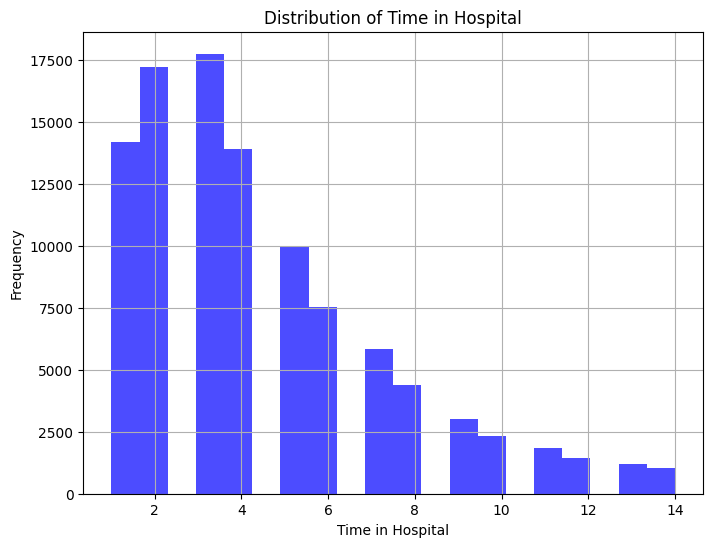

In [ ]:
# graph of stay

# Assuming you have a DataFrame X with a 'time_in_hospital' column
plt.figure(figsize=(8, 6))
plt.hist(X['time_in_hospital'], bins=20, color='blue', alpha=0.7)
plt.title('Distribution of Time in Hospital')
plt.xlabel('Time in Hospital')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [ ]:
X['rosiglitazone'].value_counts()

No        95401
Steady     6100
Up          178
Down         87
Name: rosiglitazone, dtype: int64

In [ ]:
medication_keywords = [
    "metformin", "repaglinide", "nateglinide", "chlorpropamide", "glimepiride",
    "acetohexamide", "tolazamide", "troglitazone", "miglitol", "acarbose",
    "rosiglitazone", "pioglitazone", "tolbutamide", "glyburide", "glipizide",
    "metformin-pioglitazone", "metformin-rosiglitazone",
    "glimepiride-pioglitazone", "glipizide-metformin", "glyburide-metformin",
    "insulin", "citoglipton"
]

def transform_category(category):
    if category == 'No':
      return 0
    else:
      return 1

# Create a copy of the DataFrame y
X_copy = X.copy()

for med in medication_keywords:
  X_copy[med] = X_copy[med].apply(transform_category)

In [46]:
column_sums = X_copy[medication_keywords]
# Calculate the frequency (popularity) of each medication
medication_popularity = column_sums.sum()

# Sort the medications in descending order of popularity
sorted_medication_popularity = medication_popularity.sort_values(ascending=False)

# Convert the result to a DataFrame for better display
sorted_medication_df = pd.DataFrame({'Medication': sorted_medication_popularity.index, 'Popularity': sorted_medication_popularity.values})

# Print the sorted medication popularity DataFrame
sorted_medication_df.to_csv('sorted_medication.csv', index=False)